# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### lightgbm deberta-large 5folds 

In [1]:
! nvidia-smi

Sat May  7 15:38:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[2, 3, 4]
    train=True

    name = "exp002" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=89dfc77ec38a54fcd5e0a1bb7eee462aee814c209990993114abfdd12e1b85b4
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
     |████████████████████████████████| 4.0 MB 7.9 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 24.3 MB/s 
     |████████████████████████████████| 880 kB 63.3 MB/s 
     |████████████████████████████████| 1.2 MB 25.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=887d3878c2527727ef2a9527c0e8c22cb21a66d495fa11c8271c179db9cd62e7
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

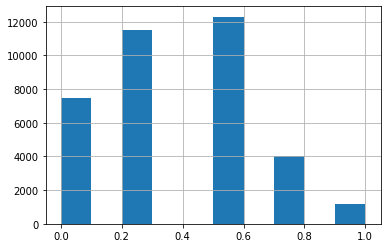

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7295
1    7295
2    7295
3    7294
4    7294
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
#     'max_depth': 5,
    # 'min_data_in_leaf': 50,   # default = 20
    # 'verbosity': -1,
    }
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=100)

    return bst

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, embed = model(inputs)
        y_preds = gbdt.predict(embed.to('cpu').numpy())
        preds.append(y_preds)

    predictions = np.concatenate(preds)
#     predictions = np.concatenate(predictions)
    return predictions


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 2 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1823] Elapsed 0m 1s (remain 36m 14s) Loss: 0.6497(0.6497) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 16s (remain 21m 48s) Loss: 0.6005(0.6409) Grad: 101008.3594  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 34s (remain 20m 50s) Loss: 0.7001(0.6106) Grad: 141517.7656  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 3m 53s (remain 19m 39s) Loss: 0.5077(0.5993) Grad: 52982.0664  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 12s (remain 18m 29s) Loss: 0.6685(0.5914) Grad: 94743.4219  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 32s (remain 17m 14s) Loss: 0.5107(0.5862) Grad: 63647.6055  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 51s (remain 15m 59s) Loss: 0.5642(0.5790) Grad: 26263.1133  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 11s (remain 14m 42s) Loss: 0.5282(0.5749) Grad: 122818.7812  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 30s (remain 13m 24s) Loss: 0.6382(0.5723) Grad: 118649.9609  LR: 0.00001941  
Epoch: [1][900/1823] Ela

Epoch 1 - Score: 0.8440


Epoch: [2][0/1823] Elapsed 0m 1s (remain 35m 11s) Loss: 0.4043(0.4043) Grad: 75546.4609  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.5129(0.5187) Grad: 43300.2930  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 36s) Loss: 0.5450(0.5145) Grad: 46373.8359  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 14s) Loss: 0.5319(0.5143) Grad: 85979.3906  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.4387(0.5147) Grad: 127386.1797  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.6432(0.5166) Grad: 41251.3438  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.3682(0.5159) Grad: 60762.6641  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.5769(0.5162) Grad: 88706.0078  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 37s (remain 13m 32s) Loss: 0.4863(0.5159) Grad: 113548.6719  LR: 0.00001426  
Epoch: [2][900/1823] 

Epoch 2 - Score: 0.8558


Epoch: [3][0/1823] Elapsed 0m 1s (remain 34m 29s) Loss: 0.4491(0.4491) Grad: 48109.4492  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 20s (remain 22m 59s) Loss: 0.5074(0.4993) Grad: 77720.5938  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 33s) Loss: 0.4636(0.4974) Grad: 106869.3516  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.3931(0.4974) Grad: 91078.6719  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 18s (remain 18m 50s) Loss: 0.5057(0.5012) Grad: 151526.5781  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 38s (remain 17m 30s) Loss: 0.4876(0.5033) Grad: 33056.5469  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.4774(0.5045) Grad: 77260.3672  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.4640(0.5046) Grad: 54289.4922  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.4578(0.5049) Grad: 68392.1641  LR: 0.00000662  
Epoch: [3][900/1823

Epoch 3 - Score: 0.8595


Epoch: [4][0/1823] Elapsed 0m 1s (remain 34m 21s) Loss: 0.4368(0.4368) Grad: 32932.0977  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 1s) Loss: 0.4715(0.4907) Grad: 26030.6816  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 34s) Loss: 0.4966(0.4952) Grad: 91992.8750  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.6122(0.4992) Grad: 34548.1367  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 19s (remain 18m 51s) Loss: 0.6296(0.5002) Grad: 174403.0938  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 38s (remain 17m 31s) Loss: 0.4129(0.4978) Grad: 76188.2969  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.7083(0.4996) Grad: 603186.0625  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.5393(0.4997) Grad: 50499.4961  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.5440(0.5001) Grad: 68062.2812  LR: 0.00000096  
Epoch: [4][900/1823]

Epoch 4 - Score: 0.8580
========== fold: 2 result ==========
Score: 0.8595
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 1s (remain 37m 35s) Loss: 0.7132(0.7132) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.6972(0.6427) Grad: 93262.8047  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 40s (remain 21m 35s) Loss: 0.6010(0.6058) Grad: 67718.2500  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 13s) Loss: 0.5394(0.5950) Grad: 56223.7539  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.4975(0.5871) Grad: 46275.8945  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 39s (remain 17m 32s) Loss: 0.5429(0.5794) Grad: 64786.8125  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.3345(0.5750) Grad: 73713.3750  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.6493(0.5719) Grad: 50423.0859  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.6450(0.5816) Grad: 3290.4124  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 11

Epoch 1 - Score: 0.8181


Epoch: [2][0/1823] Elapsed 0m 1s (remain 35m 12s) Loss: 0.5817(0.5817) Grad: 108030.7188  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 1s) Loss: 0.5214(0.5387) Grad: 76207.3359  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 33s) Loss: 0.4942(0.5363) Grad: 106347.4844  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.5446(0.5324) Grad: 35078.7578  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 19s (remain 18m 51s) Loss: 0.5551(0.5337) Grad: 39287.9336  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 38s (remain 17m 31s) Loss: 0.5257(0.5335) Grad: 40627.3945  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.4574(0.5316) Grad: 45691.6445  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.5445(0.5323) Grad: 62671.0586  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.5401(0.5337) Grad: 32466.4238  LR: 0.00001426  
Epoch: [2][900/1823]

Epoch 2 - Score: 0.8364


Epoch: [3][0/1823] Elapsed 0m 1s (remain 35m 36s) Loss: 0.6267(0.6267) Grad: 80673.5781  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 20s (remain 23m 0s) Loss: 0.5439(0.5235) Grad: 19430.8320  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 34s) Loss: 0.5401(0.5230) Grad: 65960.3047  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.4820(0.5229) Grad: 38925.6016  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 19s (remain 18m 51s) Loss: 0.5839(0.5210) Grad: 32993.1094  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 38s (remain 17m 31s) Loss: 0.5283(0.5193) Grad: 30654.5527  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.5154(0.5210) Grad: 55051.6016  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.5227(0.5205) Grad: 31066.0898  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.4642(0.5213) Grad: 44078.6602  LR: 0.00000662  
Epoch: [3][900/1823] E

Epoch 3 - Score: 0.8419


Epoch: [4][0/1823] Elapsed 0m 1s (remain 36m 0s) Loss: 0.6095(0.6095) Grad: 78872.7734  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 20s (remain 23m 0s) Loss: 0.5332(0.5129) Grad: 75940.9531  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 34s) Loss: 0.4170(0.5157) Grad: 127106.4062  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 13s) Loss: 0.4263(0.5110) Grad: 64304.3242  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 19s (remain 18m 52s) Loss: 0.4921(0.5169) Grad: 33717.6602  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.5296(0.5161) Grad: 42453.0898  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.5765(0.5160) Grad: 8322.5449  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.6007(0.5156) Grad: 8879.3838  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.5508(0.5151) Grad: 27809.6660  LR: 0.00000096  
Epoch: [4][900/1823] Elap

Epoch 4 - Score: 0.8435
========== fold: 3 result ==========
Score: 0.8435
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 1s (remain 46m 26s) Loss: 0.7083(0.7083) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 14s) Loss: 0.6090(0.6359) Grad: 13382.0225  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 41s (remain 21m 41s) Loss: 0.6518(0.6200) Grad: 32999.9102  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.6211(0.6042) Grad: 63682.6367  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 20s (remain 18m 55s) Loss: 0.5885(0.5926) Grad: 26850.3477  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 39s (remain 17m 34s) Loss: 0.4431(0.5872) Grad: 20643.3926  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 59s (remain 16m 14s) Loss: 0.6072(0.5823) Grad: 35907.6953  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 18s (remain 14m 53s) Loss: 0.6606(0.5786) Grad: 35261.2188  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 37s (remain 13m 33s) Loss: 0.5803(0.5744) Grad: 44350.2734  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 

Epoch 1 - Score: 0.8422


Epoch: [2][0/1823] Elapsed 0m 1s (remain 36m 24s) Loss: 0.6289(0.6289) Grad: 72221.9219  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.5087(0.5199) Grad: 58733.3750  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 36s) Loss: 0.4685(0.5166) Grad: 102358.2031  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 13s) Loss: 0.4591(0.5155) Grad: 21252.2969  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 19s (remain 18m 52s) Loss: 0.6399(0.5147) Grad: 46539.5898  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.5799(0.5173) Grad: 58394.9883  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.5641(0.5173) Grad: 59611.0391  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.6044(0.5187) Grad: 183764.7344  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 37s (remain 13m 33s) Loss: 0.5293(0.5193) Grad: 40852.8906  LR: 0.00001426  
Epoch: [2][900/1823] 

Epoch 2 - Score: 0.8572


Epoch: [3][0/1823] Elapsed 0m 1s (remain 35m 15s) Loss: 0.4223(0.4223) Grad: 36502.7852  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.5295(0.5008) Grad: 53539.5078  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 36s) Loss: 0.5709(0.5135) Grad: 46623.9258  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 0s (remain 20m 14s) Loss: 0.4044(0.5131) Grad: 47525.9531  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.4017(0.5125) Grad: 48564.4414  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 39s (remain 17m 33s) Loss: 0.4586(0.5084) Grad: 83177.1875  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 58s (remain 16m 13s) Loss: 0.4854(0.5073) Grad: 39305.6094  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 18s (remain 14m 53s) Loss: 0.5672(0.5059) Grad: 23577.3711  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 37s (remain 13m 33s) Loss: 0.4063(0.5060) Grad: 134518.2656  LR: 0.00000662  
Epoch: [3][900/1823] E

Epoch 3 - Score: 0.8597


Epoch: [4][0/1823] Elapsed 0m 1s (remain 36m 49s) Loss: 0.4191(0.4191) Grad: 39315.8398  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.4957(0.4958) Grad: 310082.7812  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 35s) Loss: 0.5296(0.4951) Grad: 27004.2930  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 14s) Loss: 0.3580(0.4978) Grad: 111990.7109  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.5141(0.4992) Grad: 75555.0312  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.3919(0.4991) Grad: 255597.7031  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.4969(0.5010) Grad: 158738.8906  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.4936(0.5007) Grad: 342434.6562  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.4337(0.5006) Grad: 37296.5156  LR: 0.00000096  
Epoch: [4][900/182

========== fold: 2 training ==========
Downloading: 100%
833M/833M [00:27<00:00, 58.5MB/s]
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch: [1][0/1823] Elapsed 0m 1s (remain 36m 14s) Loss: 0.6497(0.6497) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 16s (remain 21m 48s) Loss: 0.6005(0.6409) Grad: 101008.3594  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 34s (remain 20m 50s) Loss: 0.7001(0.6106) Grad: 141517.7656  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 3m 53s (remain 19m 39s) Loss: 0.5077(0.5993) Grad: 52982.0664  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 12s (remain 18m 29s) Loss: 0.6685(0.5914) Grad: 94743.4219  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 32s (remain 17m 14s) Loss: 0.5107(0.5862) Grad: 63647.6055  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 51s (remain 15m 59s) Loss: 0.5642(0.5790) Grad: 26263.1133  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 11s (remain 14m 42s) Loss: 0.5282(0.5749) Grad: 122818.7812  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 30s (remain 13m 24s) Loss: 0.6382(0.5723) Grad: 118649.9609  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 11m 50s (remain 12m 6s) Loss: 0.4388(0.5701) Grad: 93560.8828  LR: 0.00001926  
Epoch: [1][1000/1823] Elapsed 13m 9s (remain 10m 48s) Loss: 0.5570(0.5677) Grad: 28903.9805  LR: 0.00001908  
Epoch: [1][1100/1823] Elapsed 14m 29s (remain 9m 29s) Loss: 0.4635(0.5653) Grad: 54999.2773  LR: 0.00001890  
Epoch: [1][1200/1823] Elapsed 15m 48s (remain 8m 11s) Loss: 0.5640(0.5641) Grad: 88611.5234  LR: 0.00001869  
Epoch: [1][1300/1823] Elapsed 17m 7s (remain 6m 52s) Loss: 0.6069(0.5627) Grad: 49773.6328  LR: 0.00001847  
Epoch: [1][1400/1823] Elapsed 18m 27s (remain 5m 33s) Loss: 0.4767(0.5604) Grad: 67014.4609  LR: 0.00001823  
Epoch: [1][1500/1823] Elapsed 19m 46s (remain 4m 14s) Loss: 0.5667(0.5595) Grad: 28586.5332  LR: 0.00001798  
Epoch: [1][1600/1823] Elapsed 21m 6s (remain 2m 55s) Loss: 0.5668(0.5584) Grad: 141103.7812  LR: 0.00001772  
Epoch: [1][1700/1823] Elapsed 22m 25s (remain 1m 36s) Loss: 0.4112(0.5577) Grad: 22628.4199  LR: 0.00001743  
Epoch: [1][1800/1823] Elapsed 23m 44s (remain 0m 17s) Loss: 0.6236(0.5571) Grad: 18915.4375  LR: 0.00001714  
Epoch: [1][1822/1823] Elapsed 24m 2s (remain 0m 0s) Loss: 0.5163(0.5568) Grad: 60064.4727  LR: 0.00001707  
Epoch 1 - Score: 0.8440
Epoch: [2][0/1823] Elapsed 0m 1s (remain 35m 11s) Loss: 0.4043(0.4043) Grad: 75546.4609  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.5129(0.5187) Grad: 43300.2930  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 36s) Loss: 0.5450(0.5145) Grad: 46373.8359  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 14s) Loss: 0.5319(0.5143) Grad: 85979.3906  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.4387(0.5147) Grad: 127386.1797  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.6432(0.5166) Grad: 41251.3438  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.3682(0.5159) Grad: 60762.6641  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.5769(0.5162) Grad: 88706.0078  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 37s (remain 13m 32s) Loss: 0.4863(0.5159) Grad: 113548.6719  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 11m 56s (remain 12m 13s) Loss: 0.5654(0.5170) Grad: 98941.7891  LR: 0.00001387  
Epoch: [2][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.4069(0.5172) Grad: 188157.1562  LR: 0.00001347  
Epoch: [2][1100/1823] Elapsed 14m 35s (remain 9m 34s) Loss: 0.5062(0.5172) Grad: 50052.3281  LR: 0.00001306  
Epoch: [2][1200/1823] Elapsed 15m 54s (remain 8m 14s) Loss: 0.4165(0.5175) Grad: 95709.5547  LR: 0.00001265  
Epoch: [2][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.4833(0.5177) Grad: 44716.4648  LR: 0.00001223  
Epoch: [2][1400/1823] Elapsed 18m 33s (remain 5m 35s) Loss: 0.4821(0.5183) Grad: 115194.0469  LR: 0.00001181  
Epoch: [2][1500/1823] Elapsed 19m 52s (remain 4m 15s) Loss: 0.4990(0.5189) Grad: 42844.4375  LR: 0.00001139  
Epoch: [2][1600/1823] Elapsed 21m 12s (remain 2m 56s) Loss: 0.4567(0.5186) Grad: 63546.3867  LR: 0.00001096  
Epoch: [2][1700/1823] Elapsed 22m 31s (remain 1m 36s) Loss: 0.6097(0.5189) Grad: 55036.8359  LR: 0.00001053  
Epoch: [2][1800/1823] Elapsed 23m 51s (remain 0m 17s) Loss: 0.4038(0.5189) Grad: 65830.8906  LR: 0.00001010  
Epoch: [2][1822/1823] Elapsed 24m 8s (remain 0m 0s) Loss: 0.5246(0.5190) Grad: 31286.1641  LR: 0.00001000  
Epoch 2 - Score: 0.8558
Epoch: [3][0/1823] Elapsed 0m 1s (remain 34m 29s) Loss: 0.4491(0.4491) Grad: 48109.4492  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 20s (remain 22m 59s) Loss: 0.5074(0.4993) Grad: 77720.5938  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 33s) Loss: 0.4636(0.4974) Grad: 106869.3516  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.3931(0.4974) Grad: 91078.6719  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 18s (remain 18m 50s) Loss: 0.5057(0.5012) Grad: 151526.5781  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 38s (remain 17m 30s) Loss: 0.4876(0.5033) Grad: 33056.5469  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.4774(0.5045) Grad: 77260.3672  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.4640(0.5046) Grad: 54289.4922  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.4578(0.5049) Grad: 68392.1641  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 11m 55s (remain 12m 12s) Loss: 0.4931(0.5051) Grad: 55396.0664  LR: 0.00000622  
Epoch: [3][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.6206(0.5043) Grad: 157261.3594  LR: 0.00000582  
Epoch: [3][1100/1823] Elapsed 14m 34s (remain 9m 33s) Loss: 0.4708(0.5044) Grad: 70680.4453  LR: 0.00000544  
Epoch: [3][1200/1823] Elapsed 15m 53s (remain 8m 14s) Loss: 0.6376(0.5050) Grad: 77114.3203  LR: 0.00000506  
Epoch: [3][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.4713(0.5047) Grad: 30097.5371  LR: 0.00000469  
Epoch: [3][1400/1823] Elapsed 18m 32s (remain 5m 35s) Loss: 0.5578(0.5051) Grad: 124146.3750  LR: 0.00000433  
Epoch: [3][1500/1823] Elapsed 19m 52s (remain 4m 15s) Loss: 0.4278(0.5051) Grad: 60668.5430  LR: 0.00000398  
Epoch: [3][1600/1823] Elapsed 21m 11s (remain 2m 56s) Loss: 0.4886(0.5047) Grad: 83630.2031  LR: 0.00000364  
Epoch: [3][1700/1823] Elapsed 22m 30s (remain 1m 36s) Loss: 0.5731(0.5052) Grad: 178510.6250  LR: 0.00000331  
Epoch: [3][1800/1823] Elapsed 23m 50s (remain 0m 17s) Loss: 0.5266(0.5050) Grad: 46335.5742  LR: 0.00000300  
Epoch: [3][1822/1823] Elapsed 24m 7s (remain 0m 0s) Loss: 0.5159(0.5053) Grad: 50839.7812  LR: 0.00000293  
Epoch 3 - Score: 0.8595
Epoch: [4][0/1823] Elapsed 0m 1s (remain 34m 21s) Loss: 0.4368(0.4368) Grad: 32932.0977  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 1s) Loss: 0.4715(0.4907) Grad: 26030.6816  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 34s) Loss: 0.4966(0.4952) Grad: 91992.8750  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.6122(0.4992) Grad: 34548.1367  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 19s (remain 18m 51s) Loss: 0.6296(0.5002) Grad: 174403.0938  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 38s (remain 17m 31s) Loss: 0.4129(0.4978) Grad: 76188.2969  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.7083(0.4996) Grad: 603186.0625  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.5393(0.4997) Grad: 50499.4961  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.5440(0.5001) Grad: 68062.2812  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 11m 55s (remain 12m 12s) Loss: 0.5856(0.4994) Grad: 32065.9043  LR: 0.00000078  
Epoch: [4][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.3856(0.4997) Grad: 150869.4844  LR: 0.00000062  
Epoch: [4][1100/1823] Elapsed 14m 34s (remain 9m 33s) Loss: 0.4200(0.5001) Grad: 71893.2266  LR: 0.00000048  
Epoch: [4][1200/1823] Elapsed 15m 54s (remain 8m 14s) Loss: 0.5636(0.4998) Grad: 34284.3516  LR: 0.00000036  
Epoch: [4][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.5180(0.4989) Grad: 84329.5391  LR: 0.00000025  
Epoch: [4][1400/1823] Elapsed 18m 33s (remain 5m 35s) Loss: 0.5435(0.4983) Grad: 75243.4766  LR: 0.00000017  
Epoch: [4][1500/1823] Elapsed 19m 52s (remain 4m 15s) Loss: 0.5397(0.4988) Grad: 277009.6875  LR: 0.00000010  
Epoch: [4][1600/1823] Elapsed 21m 11s (remain 2m 56s) Loss: 0.4056(0.4986) Grad: 47318.6289  LR: 0.00000005  
Epoch: [4][1700/1823] Elapsed 22m 31s (remain 1m 36s) Loss: 0.3709(0.4982) Grad: 33993.8086  LR: 0.00000001  
Epoch: [4][1800/1823] Elapsed 23m 50s (remain 0m 17s) Loss: 0.4593(0.4980) Grad: 78771.8047  LR: 0.00000000  
Epoch: [4][1822/1823] Elapsed 24m 7s (remain 0m 0s) Loss: 0.5354(0.4980) Grad: 345441.4062  LR: 0.00000000  
Epoch 4 - Score: 0.8580
========== fold: 2 result ==========
Score: 0.8595
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch: [1][0/1823] Elapsed 0m 1s (remain 37m 35s) Loss: 0.7132(0.7132) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.6972(0.6427) Grad: 93262.8047  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 40s (remain 21m 35s) Loss: 0.6010(0.6058) Grad: 67718.2500  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 13s) Loss: 0.5394(0.5950) Grad: 56223.7539  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.4975(0.5871) Grad: 46275.8945  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 39s (remain 17m 32s) Loss: 0.5429(0.5794) Grad: 64786.8125  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.3345(0.5750) Grad: 73713.3750  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.6493(0.5719) Grad: 50423.0859  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.6450(0.5816) Grad: 3290.4124  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 11m 55s (remain 12m 12s) Loss: 0.6980(0.5900) Grad: 7301.7515  LR: 0.00001926  
Epoch: [1][1000/1823] Elapsed 13m 15s (remain 10m 52s) Loss: 0.6858(0.5962) Grad: 29499.7500  LR: 0.00001908  
Epoch: [1][1100/1823] Elapsed 14m 34s (remain 9m 33s) Loss: 0.6119(0.5980) Grad: 6666.2446  LR: 0.00001890  
Epoch: [1][1200/1823] Elapsed 15m 53s (remain 8m 13s) Loss: 0.6751(0.6006) Grad: 3192.7788  LR: 0.00001869  
Epoch: [1][1300/1823] Elapsed 17m 12s (remain 6m 54s) Loss: 0.5860(0.6005) Grad: 12675.6787  LR: 0.00001847  
Epoch: [1][1400/1823] Elapsed 18m 32s (remain 5m 34s) Loss: 0.4623(0.5980) Grad: 4128.8076  LR: 0.00001823  
Epoch: [1][1500/1823] Elapsed 19m 51s (remain 4m 15s) Loss: 0.4307(0.5958) Grad: 12142.6719  LR: 0.00001798  
Epoch: [1][1600/1823] Elapsed 21m 10s (remain 2m 56s) Loss: 0.5961(0.5939) Grad: 2139.0098  LR: 0.00001772  
Epoch: [1][1700/1823] Elapsed 22m 29s (remain 1m 36s) Loss: 0.5511(0.5921) Grad: 2871.1973  LR: 0.00001743  
Epoch: [1][1800/1823] Elapsed 23m 49s (remain 0m 17s) Loss: 0.5199(0.5903) Grad: 2143.2549  LR: 0.00001714  
Epoch: [1][1822/1823] Elapsed 24m 6s (remain 0m 0s) Loss: 0.5085(0.5901) Grad: 9178.2412  LR: 0.00001707  
Epoch 1 - Score: 0.8181
Epoch: [2][0/1823] Elapsed 0m 1s (remain 35m 12s) Loss: 0.5817(0.5817) Grad: 108030.7188  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 1s) Loss: 0.5214(0.5387) Grad: 76207.3359  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 33s) Loss: 0.4942(0.5363) Grad: 106347.4844  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.5446(0.5324) Grad: 35078.7578  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 19s (remain 18m 51s) Loss: 0.5551(0.5337) Grad: 39287.9336  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 38s (remain 17m 31s) Loss: 0.5257(0.5335) Grad: 40627.3945  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.4574(0.5316) Grad: 45691.6445  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.5445(0.5323) Grad: 62671.0586  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.5401(0.5337) Grad: 32466.4238  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 11m 55s (remain 12m 12s) Loss: 0.6262(0.5340) Grad: 28580.6484  LR: 0.00001387  
Epoch: [2][1000/1823] Elapsed 13m 15s (remain 10m 52s) Loss: 0.5761(0.5329) Grad: 88687.6094  LR: 0.00001347  
Epoch: [2][1100/1823] Elapsed 14m 34s (remain 9m 33s) Loss: 0.4730(0.5323) Grad: 24912.7754  LR: 0.00001306  
Epoch: [2][1200/1823] Elapsed 15m 53s (remain 8m 13s) Loss: 0.5510(0.5325) Grad: 54152.4219  LR: 0.00001265  
Epoch: [2][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.6536(0.5322) Grad: 138190.0781  LR: 0.00001223  
Epoch: [2][1400/1823] Elapsed 18m 32s (remain 5m 35s) Loss: 0.5374(0.5315) Grad: 42235.8672  LR: 0.00001181  
Epoch: [2][1500/1823] Elapsed 19m 51s (remain 4m 15s) Loss: 0.4945(0.5315) Grad: 110930.1406  LR: 0.00001139  
Epoch: [2][1600/1823] Elapsed 21m 11s (remain 2m 56s) Loss: 0.4604(0.5305) Grad: 45131.3555  LR: 0.00001096  
Epoch: [2][1700/1823] Elapsed 22m 30s (remain 1m 36s) Loss: 0.4953(0.5307) Grad: 53752.0391  LR: 0.00001053  
Epoch: [2][1800/1823] Elapsed 23m 50s (remain 0m 17s) Loss: 0.5013(0.5308) Grad: 39656.5352  LR: 0.00001010  
Epoch: [2][1822/1823] Elapsed 24m 7s (remain 0m 0s) Loss: 0.5635(0.5311) Grad: 22294.6719  LR: 0.00001000  
Epoch 2 - Score: 0.8364
Epoch: [3][0/1823] Elapsed 0m 1s (remain 35m 36s) Loss: 0.6267(0.6267) Grad: 80673.5781  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 20s (remain 23m 0s) Loss: 0.5439(0.5235) Grad: 19430.8320  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 34s) Loss: 0.5401(0.5230) Grad: 65960.3047  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 3m 59s (remain 20m 11s) Loss: 0.4820(0.5229) Grad: 38925.6016  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 19s (remain 18m 51s) Loss: 0.5839(0.5210) Grad: 32993.1094  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 38s (remain 17m 31s) Loss: 0.5283(0.5193) Grad: 30654.5527  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.5154(0.5210) Grad: 55051.6016  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.5227(0.5205) Grad: 31066.0898  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.4642(0.5213) Grad: 44078.6602  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 11m 56s (remain 12m 12s) Loss: 0.4994(0.5208) Grad: 37029.3633  LR: 0.00000622  
Epoch: [3][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.4827(0.5220) Grad: 12980.9053  LR: 0.00000582  
Epoch: [3][1100/1823] Elapsed 14m 35s (remain 9m 33s) Loss: 0.4934(0.5210) Grad: 55536.1367  LR: 0.00000544  
Epoch: [3][1200/1823] Elapsed 15m 54s (remain 8m 14s) Loss: 0.5389(0.5211) Grad: 21424.7715  LR: 0.00000506  
Epoch: [3][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.4712(0.5208) Grad: 23457.7539  LR: 0.00000469  
Epoch: [3][1400/1823] Elapsed 18m 33s (remain 5m 35s) Loss: 0.5088(0.5212) Grad: 33043.0156  LR: 0.00000433  
Epoch: [3][1500/1823] Elapsed 19m 52s (remain 4m 15s) Loss: 0.5682(0.5209) Grad: 39072.3047  LR: 0.00000398  
Epoch: [3][1600/1823] Elapsed 21m 11s (remain 2m 56s) Loss: 0.4764(0.5208) Grad: 68204.5547  LR: 0.00000364  
Epoch: [3][1700/1823] Elapsed 22m 31s (remain 1m 36s) Loss: 0.5173(0.5199) Grad: 16844.7148  LR: 0.00000331  
Epoch: [3][1800/1823] Elapsed 23m 50s (remain 0m 17s) Loss: 0.5368(0.5197) Grad: 16159.4678  LR: 0.00000300  
Epoch: [3][1822/1823] Elapsed 24m 8s (remain 0m 0s) Loss: 0.4668(0.5198) Grad: 31714.6309  LR: 0.00000293  
Epoch 3 - Score: 0.8419
Epoch: [4][0/1823] Elapsed 0m 1s (remain 36m 0s) Loss: 0.6095(0.6095) Grad: 78872.7734  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 20s (remain 23m 0s) Loss: 0.5332(0.5129) Grad: 75940.9531  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 34s) Loss: 0.4170(0.5157) Grad: 127106.4062  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 13s) Loss: 0.4263(0.5110) Grad: 64304.3242  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 19s (remain 18m 52s) Loss: 0.4921(0.5169) Grad: 33717.6602  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.5296(0.5161) Grad: 42453.0898  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 7m 57s (remain 16m 11s) Loss: 0.5765(0.5160) Grad: 8322.5449  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 17s (remain 14m 51s) Loss: 0.6007(0.5156) Grad: 8879.3838  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.5508(0.5151) Grad: 27809.6660  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 11m 55s (remain 12m 12s) Loss: 0.5100(0.5144) Grad: 18676.7383  LR: 0.00000078  
Epoch: [4][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.5443(0.5141) Grad: 13869.3223  LR: 0.00000062  
Epoch: [4][1100/1823] Elapsed 14m 34s (remain 9m 33s) Loss: 0.4313(0.5144) Grad: 14259.0254  LR: 0.00000048  
Epoch: [4][1200/1823] Elapsed 15m 53s (remain 8m 14s) Loss: 0.4822(0.5143) Grad: 25162.3418  LR: 0.00000036  
Epoch: [4][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.5543(0.5138) Grad: 24033.1484  LR: 0.00000025  
Epoch: [4][1400/1823] Elapsed 18m 32s (remain 5m 35s) Loss: 0.4899(0.5134) Grad: nan  LR: 0.00000017  
Epoch: [4][1500/1823] Elapsed 19m 52s (remain 4m 15s) Loss: 0.4953(0.5138) Grad: 16676.4043  LR: 0.00000010  
Epoch: [4][1600/1823] Elapsed 21m 11s (remain 2m 56s) Loss: 0.5047(0.5133) Grad: 21039.6016  LR: 0.00000005  
Epoch: [4][1700/1823] Elapsed 22m 30s (remain 1m 36s) Loss: 0.5879(0.5130) Grad: 14502.4404  LR: 0.00000001  
Epoch: [4][1800/1823] Elapsed 23m 49s (remain 0m 17s) Loss: 0.4964(0.5130) Grad: 7312.9067  LR: 0.00000000  
Epoch: [4][1822/1823] Elapsed 24m 7s (remain 0m 0s) Loss: 0.4798(0.5129) Grad: 4703.6816  LR: 0.00000000  
Epoch 4 - Score: 0.8435
========== fold: 3 result ==========
Score: 0.8435
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch: [1][0/1823] Elapsed 0m 1s (remain 46m 26s) Loss: 0.7083(0.7083) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 14s) Loss: 0.6090(0.6359) Grad: 13382.0225  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 41s (remain 21m 41s) Loss: 0.6518(0.6200) Grad: 32999.9102  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.6211(0.6042) Grad: 63682.6367  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 20s (remain 18m 55s) Loss: 0.5885(0.5926) Grad: 26850.3477  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 39s (remain 17m 34s) Loss: 0.4431(0.5872) Grad: 20643.3926  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 59s (remain 16m 14s) Loss: 0.6072(0.5823) Grad: 35907.6953  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 18s (remain 14m 53s) Loss: 0.6606(0.5786) Grad: 35261.2188  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 37s (remain 13m 33s) Loss: 0.5803(0.5744) Grad: 44350.2734  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 11m 57s (remain 12m 13s) Loss: 0.5737(0.5714) Grad: 24012.5938  LR: 0.00001926  
Epoch: [1][1000/1823] Elapsed 13m 16s (remain 10m 54s) Loss: 0.5064(0.5692) Grad: 20444.1172  LR: 0.00001908  
Epoch: [1][1100/1823] Elapsed 14m 35s (remain 9m 34s) Loss: 0.5192(0.5678) Grad: 86727.2031  LR: 0.00001890  
Epoch: [1][1200/1823] Elapsed 15m 55s (remain 8m 14s) Loss: 0.5619(0.5663) Grad: 37895.1289  LR: 0.00001869  
Epoch: [1][1300/1823] Elapsed 17m 15s (remain 6m 55s) Loss: 0.7438(0.5645) Grad: 39422.8906  LR: 0.00001847  
Epoch: [1][1400/1823] Elapsed 18m 34s (remain 5m 35s) Loss: 0.6196(0.5636) Grad: 29232.6992  LR: 0.00001823  
Epoch: [1][1500/1823] Elapsed 19m 53s (remain 4m 16s) Loss: 0.6024(0.5622) Grad: 10531.4062  LR: 0.00001798  
Epoch: [1][1600/1823] Elapsed 21m 13s (remain 2m 56s) Loss: 0.6168(0.5605) Grad: 91555.8047  LR: 0.00001772  
Epoch: [1][1700/1823] Elapsed 22m 32s (remain 1m 37s) Loss: 0.6307(0.5592) Grad: 129367.1172  LR: 0.00001743  
Epoch: [1][1800/1823] Elapsed 23m 51s (remain 0m 17s) Loss: 0.6052(0.5587) Grad: 35794.1992  LR: 0.00001714  
Epoch: [1][1822/1823] Elapsed 24m 9s (remain 0m 0s) Loss: 0.6509(0.5587) Grad: 47195.4727  LR: 0.00001707  
Epoch 1 - Score: 0.8422
Epoch: [2][0/1823] Elapsed 0m 1s (remain 36m 24s) Loss: 0.6289(0.6289) Grad: 72221.9219  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.5087(0.5199) Grad: 58733.3750  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 36s) Loss: 0.4685(0.5166) Grad: 102358.2031  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 13s) Loss: 0.4591(0.5155) Grad: 21252.2969  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 19s (remain 18m 52s) Loss: 0.6399(0.5147) Grad: 46539.5898  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.5799(0.5173) Grad: 58394.9883  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.5641(0.5173) Grad: 59611.0391  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.6044(0.5187) Grad: 183764.7344  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 37s (remain 13m 33s) Loss: 0.5293(0.5193) Grad: 40852.8906  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 11m 56s (remain 12m 13s) Loss: 0.5812(0.5194) Grad: 38961.2891  LR: 0.00001387  
Epoch: [2][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.4374(0.5187) Grad: 89551.0078  LR: 0.00001347  
Epoch: [2][1100/1823] Elapsed 14m 35s (remain 9m 33s) Loss: 0.4546(0.5181) Grad: 93270.7500  LR: 0.00001306  
Epoch: [2][1200/1823] Elapsed 15m 54s (remain 8m 14s) Loss: 0.4733(0.5176) Grad: 26918.8340  LR: 0.00001265  
Epoch: [2][1300/1823] Elapsed 17m 14s (remain 6m 54s) Loss: 0.5641(0.5181) Grad: 58517.0430  LR: 0.00001223  
Epoch: [2][1400/1823] Elapsed 18m 33s (remain 5m 35s) Loss: 0.4537(0.5178) Grad: 75098.1641  LR: 0.00001181  
Epoch: [2][1500/1823] Elapsed 19m 52s (remain 4m 15s) Loss: 0.5806(0.5180) Grad: 28641.3594  LR: 0.00001139  
Epoch: [2][1600/1823] Elapsed 21m 11s (remain 2m 56s) Loss: 0.4052(0.5176) Grad: 57626.5469  LR: 0.00001096  
Epoch: [2][1700/1823] Elapsed 22m 31s (remain 1m 36s) Loss: 0.5166(0.5173) Grad: 20548.9727  LR: 0.00001053  
Epoch: [2][1800/1823] Elapsed 23m 50s (remain 0m 17s) Loss: 0.6145(0.5176) Grad: 280371.7812  LR: 0.00001010  
Epoch: [2][1822/1823] Elapsed 24m 8s (remain 0m 0s) Loss: 0.4610(0.5177) Grad: 60186.6992  LR: 0.00001000  
Epoch 2 - Score: 0.8572
Epoch: [3][0/1823] Elapsed 0m 1s (remain 35m 15s) Loss: 0.4223(0.4223) Grad: 36502.7852  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.5295(0.5008) Grad: 53539.5078  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 36s) Loss: 0.5709(0.5135) Grad: 46623.9258  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 0s (remain 20m 14s) Loss: 0.4044(0.5131) Grad: 47525.9531  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.4017(0.5125) Grad: 48564.4414  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 39s (remain 17m 33s) Loss: 0.4586(0.5084) Grad: 83177.1875  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 58s (remain 16m 13s) Loss: 0.4854(0.5073) Grad: 39305.6094  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 18s (remain 14m 53s) Loss: 0.5672(0.5059) Grad: 23577.3711  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 37s (remain 13m 33s) Loss: 0.4063(0.5060) Grad: 134518.2656  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 11m 56s (remain 12m 13s) Loss: 0.5594(0.5071) Grad: 37392.4609  LR: 0.00000622  
Epoch: [3][1000/1823] Elapsed 13m 16s (remain 10m 54s) Loss: 0.5662(0.5078) Grad: 93460.9297  LR: 0.00000582  
Epoch: [3][1100/1823] Elapsed 14m 36s (remain 9m 34s) Loss: 0.3893(0.5087) Grad: 45139.3242  LR: 0.00000544  
Epoch: [3][1200/1823] Elapsed 15m 55s (remain 8m 14s) Loss: 0.4684(0.5083) Grad: 710351.7500  LR: 0.00000506  
Epoch: [3][1300/1823] Elapsed 17m 15s (remain 6m 55s) Loss: 0.4731(0.5085) Grad: 169139.3281  LR: 0.00000469  
Epoch: [3][1400/1823] Elapsed 18m 34s (remain 5m 35s) Loss: 0.5410(0.5077) Grad: 29225.0820  LR: 0.00000433  
Epoch: [3][1500/1823] Elapsed 19m 54s (remain 4m 16s) Loss: 0.5133(0.5073) Grad: 85989.9453  LR: 0.00000398  
Epoch: [3][1600/1823] Elapsed 21m 13s (remain 2m 56s) Loss: 0.3683(0.5076) Grad: 54135.8203  LR: 0.00000364  
Epoch: [3][1700/1823] Elapsed 22m 33s (remain 1m 37s) Loss: 0.5719(0.5071) Grad: 41580.5703  LR: 0.00000331  
Epoch: [3][1800/1823] Elapsed 23m 52s (remain 0m 17s) Loss: 0.4310(0.5065) Grad: 50621.5469  LR: 0.00000300  
Epoch: [3][1822/1823] Elapsed 24m 10s (remain 0m 0s) Loss: 0.3110(0.5064) Grad: 54469.4531  LR: 0.00000293  
Epoch 3 - Score: 0.8597
Epoch: [4][0/1823] Elapsed 0m 1s (remain 36m 49s) Loss: 0.4191(0.4191) Grad: 39315.8398  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.4957(0.4958) Grad: 310082.7812  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 35s) Loss: 0.5296(0.4951) Grad: 27004.2930  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 14s) Loss: 0.3580(0.4978) Grad: 111990.7109  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 19s (remain 18m 53s) Loss: 0.5141(0.4992) Grad: 75555.0312  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 38s (remain 17m 32s) Loss: 0.3919(0.4991) Grad: 255597.7031  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 7m 58s (remain 16m 12s) Loss: 0.4969(0.5010) Grad: 158738.8906  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 17s (remain 14m 52s) Loss: 0.4936(0.5007) Grad: 342434.6562  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 36s (remain 13m 32s) Loss: 0.4337(0.5006) Grad: 37296.5156  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 11m 56s (remain 12m 12s) Loss: 0.5581(0.5011) Grad: 26850.4727  LR: 0.00000078  
Epoch: [4][1000/1823] Elapsed 13m 15s (remain 10m 53s) Loss: 0.4384(0.5023) Grad: 61612.5703  LR: 0.00000062  
Epoch: [4][1100/1823] Elapsed 14m 34s (remain 9m 33s) Loss: 0.3885(0.5007) Grad: 247470.8594  LR: 0.00000048  
Epoch: [4][1200/1823] Elapsed 15m 54s (remain 8m 14s) Loss: 0.4615(0.5005) Grad: 24555.4102  LR: 0.00000036  
Epoch: [4][1300/1823] Elapsed 17m 13s (remain 6m 54s) Loss: 0.6163(0.5005) Grad: 143229.4219  LR: 0.00000025  